In [21]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = ''
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/cs229/')

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My Drive/cs229/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs229


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer

import string
import nltk
from nltk.corpus import stopwords

DATA CLEANING

In [23]:
data1 = pd.read_csv('./spam.csv',delimiter=',',encoding='latin-1').drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1).rename(columns={'v1':'type', 'v2':'text'})
data2 = pd.read_csv('./spamraw.csv',delimiter=',',encoding='latin-1')
data3 = pd.read_csv('./real.csv',delimiter=',',encoding='latin-1')

df = data1.append(data2)
df = df.append(data3)

In [24]:
df = df.rename(columns={'type':'label', 'text':'message'})
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [25]:
df.describe()

,label,message
count,11171,11171
unique,2,6106
top,ham,"Sorry, I'll call later"
freq,9669,60


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of ham and spam messages')

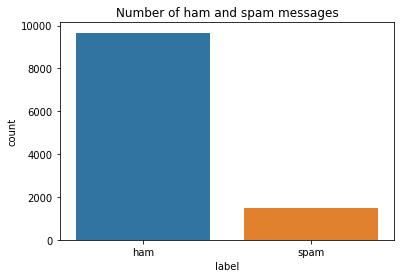

In [26]:
sns.countplot(df.label)
plt.xlabel('label')
plt.title('Number of ham and spam messages')

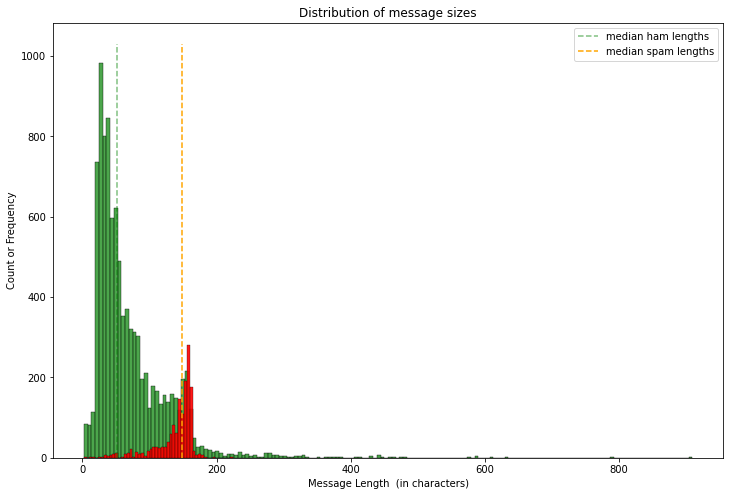

In [27]:
df['len'] = df['message'].apply(len)
fig,ax=plt.subplots(figsize=(12,8))
check = 'ham'
sns.histplot(df[df['label']==check],x='len',color='green',ax=ax,alpha=0.7)
ymin, ymax = plt.gca().get_ylim()
plt.vlines(x=df.loc[df['label']==check,'len'].median(),ymin=ymin,ymax=ymax,color='green',alpha=0.5,linestyles='dashed')
check = 'spam'
sns.histplot(df[df['label']==check],x='len',color='red',ax=ax,alpha=0.9)
plt.vlines(x=df.loc[df['label']==check,'len'].median(),ymin=ymin,ymax=ymax,color='orange',linestyles='dashed')

plt.legend(['median ham lengths','median spam lengths'])
_=plt.title('Distribution of message sizes')
_=plt.ylabel('Count or Frequency')
_=plt.xlabel('Message Length  (in characters)')

In [28]:
X = df.message
Y = df.label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

FEATURE EXTRACTION


In [29]:
from sklearn.pipeline import FeatureUnion 
#FeatureUnion is used to concat feaatures obtained using different transform functions
from sklearn.preprocessing import FunctionTransformer
#FunctionTransformer can create a transform function from any arbitrary or user defined function
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.manifold import TSNE

In [30]:
"""
Takes in a string of text, then normalize it:
"""

nltk.download('stopwords')
def text_perprocessing(message):
    # 1. Removes all punctuation
    nopunc = [char for char in message if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    # 2. Removes all stopwords
    stop_words = set(stopwords.words('english'))
    nostop = [word.lower() for word in nopunc.split() if word.lower() not in stop_words]

    return " ".join(nostop)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


COUNT VECTORIZER

In [31]:
cv = CountVectorizer(analyzer=text_perprocessing)
X_transform = cv.fit_transform(X)

TF-IDF

In [12]:
def get_length(df): return csr_matrix(df.apply(len).to_numpy().reshape(-1,1))

feature_pipe = FeatureUnion([('tfidf',TfidfVectorizer(analyzer=text_perprocessing)), ('length',FunctionTransformer(get_length))])

X_transform = feature_pipe.fit_transform(X)

(X_transform.toarray().size)

916022

TRANSFORMER BASED FEATURES

In [ ]:
!pip install transformers

In [16]:
import torch
import transformers
from nltk.tokenize import word_tokenize
import numpy as np


In [32]:
 # take over whatever gpus are on the system
device = 'cpu'
gpu_ids = []
if torch.cuda.is_available():
    gpu_ids += [gpu_id for gpu_id in range(torch.cuda.device_count())]
    device = torch.device(f'cuda:{gpu_ids[0]}')
    torch.cuda.set_device(device)
else:
    device = torch.device('cpu')

# Loading pretrained model/tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")

tokenized = df["message"].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
max_len = tokenized.apply(len).max() # get the length of the longest tokenized sentence

padded = np.array([i + [0] * (max_len-len(i)) for i in tokenized.values]) # padd the rest of the sentence with zeros if the sentence is smaller than the longest sentence

attention_mask = np.where(padded != 0, 1, 0)

input_ids = torch.tensor(padded)  # create a torch tensor for the padded sentences
input_ids = input_ids.to(device)
attention_mask = torch.tensor(attention_mask) # create a torch tensor for the attention matrix
attention_mask = attention_mask.to(device)
model = model.to(device)
encoder_hidden_state = None

with torch.no_grad():
    encoder_hidden_state = model(input_ids, attention_mask=attention_mask)

X = encoder_hidden_state[0][:,0,:].numpy()
X_transform = np.hstack((X, df[["num_words", "message_len"]].to_numpy().reshape(-1, 2))) # addind the the engineered features from the beginning

TEXT2SEQ

In [ ]:
!pip install tensorflow==2.5.0

In [35]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

%matplotlib inline

In [36]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
X_transform = sequence.pad_sequences(sequences,maxlen=max_len)


In [37]:
# SPLIT DATASETß
X_train,X_test,Y_train,Y_test = train_test_split(X_transform,Y,test_size=0.2)

TRADITIONAL ML MODELS


In [38]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve

In [39]:
def eval_result(X_test, y_test, pred):
  print(classification_report(y_test, pred, target_names = ['Ham', 'Spam']))
  display(pd.DataFrame(confusion_matrix(y_test, pred), 
                    columns = ['Predicted Ham', 'Predicted Spam'],
                    index = ['Ham', 'Spam']))
  
  print(f'Accuracy: {round(accuracy_score(y_test, pred), 5)}')

  fig = plt.figure(figsize=(10,4))
  heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(y_test, pred)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
  plt.ylabel('Ground Truth')
  plt.xlabel('Prediction')
  plt.show()

  precision, recall, thresholds = precision_recall_curve(y_test, pred)

  fig, ax = plt.subplots(figsize=(6,6))
  ax.plot(recall, precision, label='Model')
  ax.set_xlabel('Recall')
  ax.set_ylabel('Precision')
  ax.legend(loc='center left');

              precision    recall  f1-score   support

         Ham       0.94      0.77      0.85      1932
        Spam       0.32      0.70      0.44       303

    accuracy                           0.76      2235
   macro avg       0.63      0.74      0.64      2235
weighted avg       0.86      0.76      0.79      2235



,Predicted Ham,Predicted Spam
Ham,1483,449
Spam,90,213


Accuracy: 0.75884


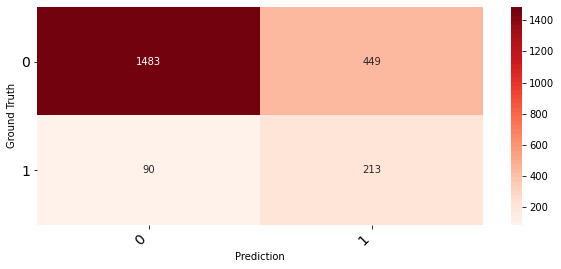

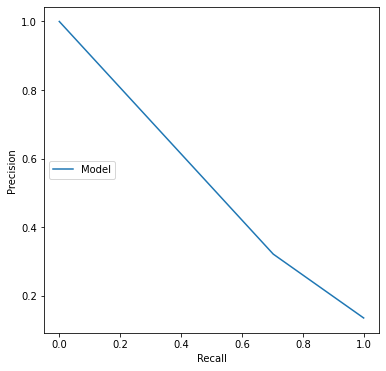

In [40]:
# NAIVE BAYES
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, Y_train.reshape(len(Y_train), ))

nb_pred = nb.predict(X_test)
eval_result(X_test, Y_test.reshape(len(Y_test), ), nb_pred)

              precision    recall  f1-score   support

         Ham       0.89      0.96      0.92      1932
        Spam       0.50      0.26      0.34       303

    accuracy                           0.86      2235
   macro avg       0.69      0.61      0.63      2235
weighted avg       0.84      0.86      0.84      2235



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Predicted Ham,Predicted Spam
Ham,1853,79
Spam,225,78


Accuracy: 0.86398


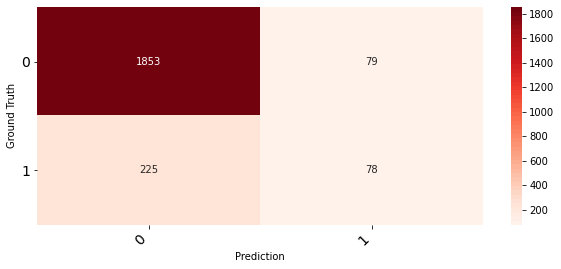

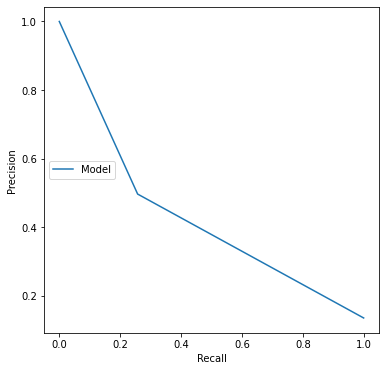

In [41]:
# LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, Y_train.reshape(len(Y_train), ))

lr_pred = lr.predict(X_test)
eval_result(X_test, Y_test.reshape(len(Y_test), ), lr_pred)

              precision    recall  f1-score   support

         Ham       0.92      0.99      0.95      1932
        Spam       0.84      0.48      0.61       303

    accuracy                           0.92      2235
   macro avg       0.88      0.73      0.78      2235
weighted avg       0.91      0.92      0.91      2235



,Predicted Ham,Predicted Spam
Ham,1905,27
Spam,157,146


Accuracy: 0.91767


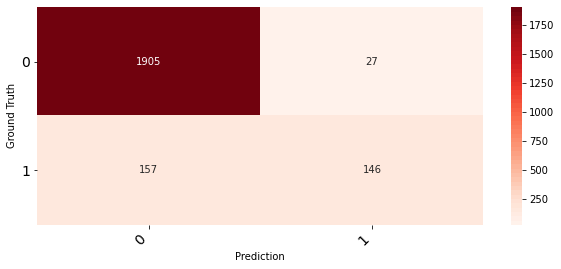

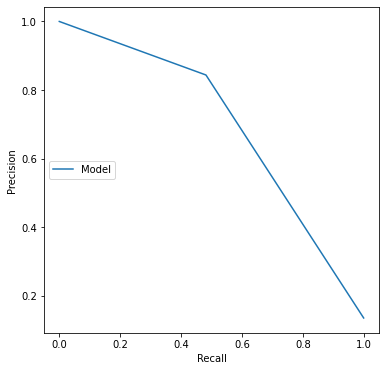

In [42]:
# SVM
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, Y_train.reshape(len(Y_train), ))

svm_pred = svm.predict(X_test)
eval_result(X_test, Y_test.reshape(len(Y_test), ), svm_pred)

              precision    recall  f1-score   support

         Ham       0.93      0.99      0.96      1932
        Spam       0.86      0.56      0.68       303

    accuracy                           0.93      2235
   macro avg       0.90      0.77      0.82      2235
weighted avg       0.92      0.93      0.92      2235



,Predicted Ham,Predicted Spam
Ham,1904,28
Spam,133,170


Accuracy: 0.92796


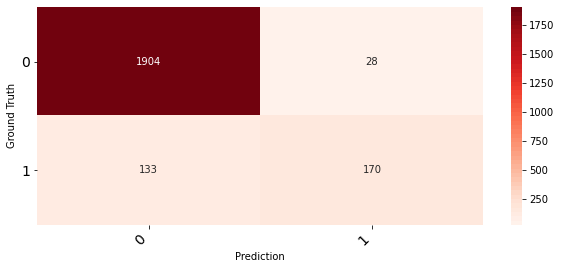

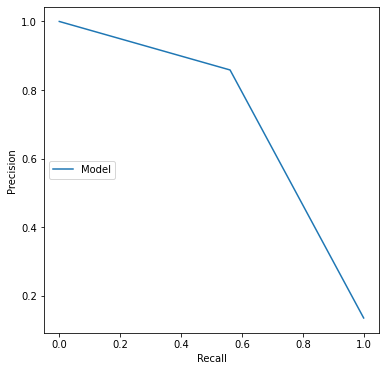

In [43]:
# K-NEAREST NEIGHBORS
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, Y_train.reshape(len(Y_train), ))

neigh_pred = neigh.predict(X_test)
eval_result(X_test, Y_test.reshape(len(Y_test), ), neigh_pred)

              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99      1932
        Spam       0.99      0.89      0.94       303

    accuracy                           0.98      2235
   macro avg       0.98      0.95      0.96      2235
weighted avg       0.98      0.98      0.98      2235



,Predicted Ham,Predicted Spam
Ham,1928,4
Spam,32,271


Accuracy: 0.98389


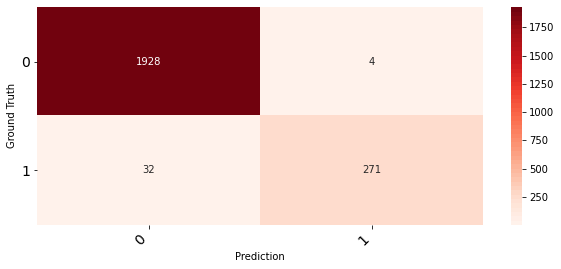

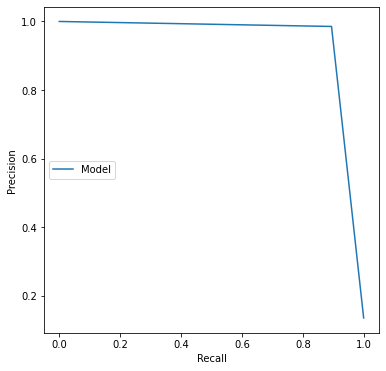

In [44]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs = -1, random_state = 1)
rfc.fit(X_train, Y_train.reshape(len(Y_train), ))

rfc_pred = rfc.predict(X_test)
eval_result(X_test, Y_test.reshape(len(Y_test), ), rfc_pred)

DEEP LEARNING MODELS

LSTM

In [45]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Convolution1D, MaxPooling1D, Flatten, LeakyReLU, ReLU
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

In [46]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = Dropout(0.4)(layer)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = LeakyReLU(alpha=0.1)(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    
    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           50000     
_________________________________________________________________
dropout (Dropout)            (None, 150, 50)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0     

In [47]:
model.fit(X_train, Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
56/56 [==============================] - 22s 29ms/step - loss: 0.3445 - accuracy: 0.8948 - val_loss: 0.0606 - val_accuracy: 0.9832


              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99      1932
        Spam       0.97      0.88      0.92       303

    accuracy                           0.98      2235
   macro avg       0.98      0.94      0.96      2235
weighted avg       0.98      0.98      0.98      2235



,Predicted Ham,Predicted Spam
Ham,1925,7
Spam,37,266


Accuracy: 0.98031


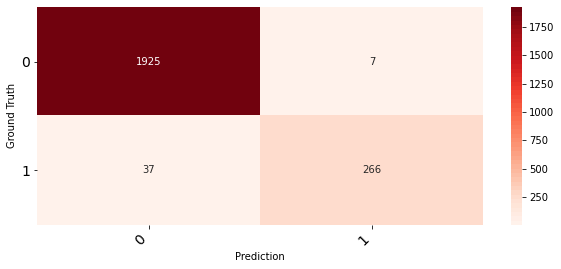

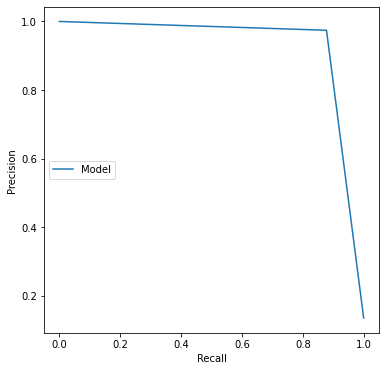

In [48]:
pred = model.predict(X_test)
pred[pred >= 0.5] = 1
pred[pred < 0.5] = 0

eval_result(X_test, Y_test.reshape(len(Y_test), ), pred)

CNN

In [49]:
def CNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,64,input_length=max_len)(inputs)
    layer = Convolution1D(filters=32, kernel_size=3, input_shape=(max_len, 64))(layer)
    layer = MaxPooling1D(pool_size=2)(layer)
    layer = LeakyReLU(alpha=0.1)(layer)
    layer = Flatten()(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    
    return model

model = CNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 64)           64000     
_________________________________________________________________
conv1d (Conv1D)              (None, 148, 32)           6176      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 74, 32)            0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 74, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2368)              0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 2369

In [50]:
model.fit(X_train, Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
56/56 [==============================] - 16s 14ms/step - loss: 0.4240 - accuracy: 0.8100 - val_loss: 0.1495 - val_accuracy: 0.9502


              precision    recall  f1-score   support

         Ham       0.94      1.00      0.97      1932
        Spam       0.99      0.59      0.74       303

    accuracy                           0.94      2235
   macro avg       0.97      0.80      0.86      2235
weighted avg       0.95      0.94      0.94      2235



,Predicted Ham,Predicted Spam
Ham,1931,1
Spam,123,180


Accuracy: 0.94452


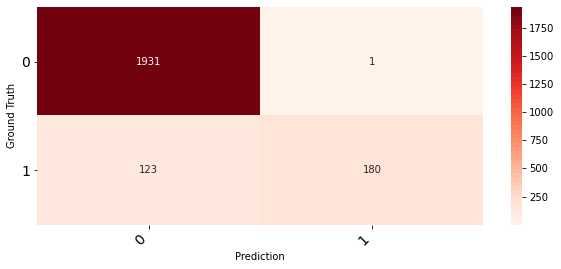

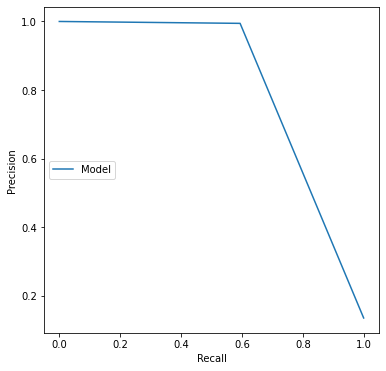

In [51]:
pred = model.predict(X_test)

pred[pred >= 0.5] = 1
pred[pred < 0.5] = 0

eval_result(X_test, Y_test.reshape(len(Y_test), ), pred)

CNN + LSTM

In [52]:
def CNN_LSTM():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,64,input_length=max_len)(inputs)
    layer = Convolution1D(filters=32, kernel_size=3, input_shape=(max_len, 64))(layer)
    layer = MaxPooling1D(pool_size=2)(layer)
    # layer = ReLU()(layer)
    
    layer = LSTM(64)(layer)
   
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    
    return model

model = CNN_LSTM()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 64)           64000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 148, 32)           6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 74, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
out_layer (Dense)            (None, 1)                 65        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0   

In [53]:
 model.fit(X_train, Y_train,batch_size=128,epochs=10,
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])

Epoch 1/10
56/56 [==============================] - 3s 23ms/step - loss: 0.3549 - accuracy: 0.8798 - val_loss: 0.0716 - val_accuracy: 0.9815


              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99      1932
        Spam       0.97      0.84      0.90       303

    accuracy                           0.97      2235
   macro avg       0.97      0.92      0.94      2235
weighted avg       0.97      0.97      0.97      2235



,Predicted Ham,Predicted Spam
Ham,1923,9
Spam,48,255


Accuracy: 0.9745


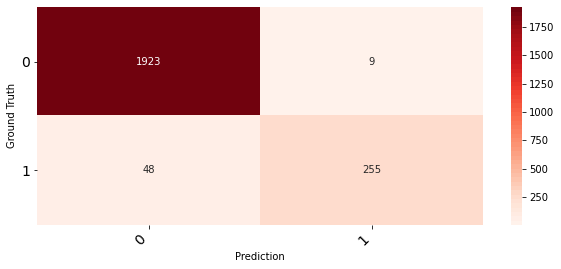

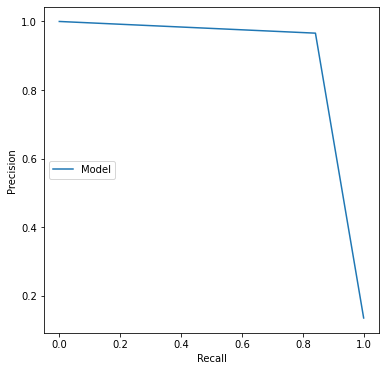

In [54]:
pred = model.predict(X_test)
pred[pred >= 0.5] = 1
pred[pred < 0.5] = 0

eval_result(X_test, Y_test.reshape(len(Y_test), ), pred)